# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [954]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import project_tests as t
import pickle
import re
import random



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /Users/chrismo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chrismo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrismo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [736]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [225]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [596]:
df_content.article_id.sort_values()

0          0
1          1
2          2
3          3
4          4
        ... 
1051    1046
1052    1047
1053    1048
1054    1049
1055    1050
Name: article_id, Length: 1051, dtype: int64

In [592]:
df_content['doc_description'].sample().values

array(['Cloudant Geospatial lets you run Nearest Neighbor queries to locate items close to a specific location.'],
      dtype=object)

In [588]:
df_content['doc_body'].sample().values

array(['* Home\r\n * Community\r\n * Projects\r\n * Blog\r\n * About\r\n * Advisory Council\r\n * Resources * Code\r\n    * Contributions\r\n    * University\r\n    * IBM Design\r\n    * Apache SystemML\r\n    * Apache Spark™\r\n   \r\n   \r\n\r\nSPARK.TC ☰ * Community\r\n * Projects\r\n * Blog\r\n * About\r\n * Advisory Council\r\n * Resources * Code\r\n    * Contributions\r\n    * University\r\n    * IBM Design\r\n    * Apache SystemML\r\n    * Apache Spark™\r\n   \r\n   \r\n\r\nSTREAMING\r\nEXTEND STRUCTURED STREAMING FOR SPARK ML\r\nEARLY METHODS TO INTEGRATE MACHINE LEARNING USING NAIVE BAYES AND CUSTOM SINKS.\r\nTo learn more about Structured Streaming and Machine Learning, check out Holden\r\nKarau’s and Seth Hendrickson’s session Spark Structured Streaming for machine learning at Strata + Hadoop World New York from 2:05pm to 2:45pm, Thursday September\r\n29th.\r\n\r\nSpark’s new ALPHA Structured Streaming API has caused a lot of excitement because it brings the Data set/DataFra

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

A. Grouping by User count

In [228]:
user_interaction = df.groupby('email').count()['article_id']

In [229]:
user_interaction

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

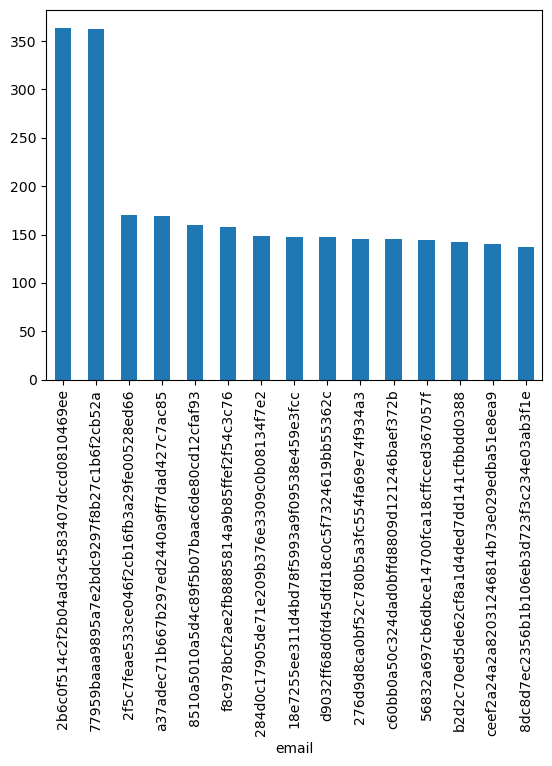

In [230]:
user_interaction.sort_values(ascending=False).head(15).plot(kind='bar');

B. Grouping by Article counts

In [232]:
article_counts = df.groupby('article_id').count()['email']

In [233]:
article_counts

article_id
0.0       14
2.0       58
4.0       13
8.0       85
9.0       10
          ..
1440.0    10
1441.0     8
1442.0     4
1443.0    22
1444.0     5
Name: email, Length: 714, dtype: int64

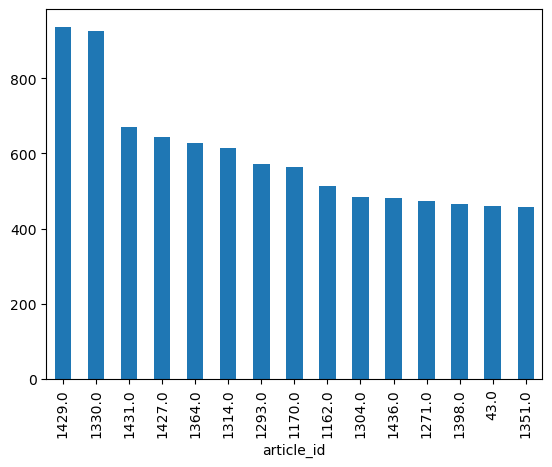

In [234]:
article_counts.sort_values(ascending=False).head(15).plot(kind='bar');

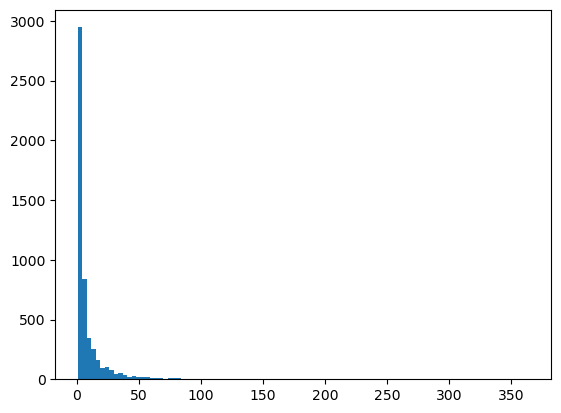

In [235]:
plt.hist(user_interaction, bins=100);

In [236]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby('email').article_id.count().median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = user_interaction.sort_values(ascending=False).max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [238]:
# Find and explore duplicate articles

In [239]:
df_content['article_id'].duplicated().sum()

5

In [240]:
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [241]:
# Remove any rows that have the same article_id - only keep the first

In [242]:
df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [243]:
df_content['article_id'].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [245]:
df.groupby('article_id')['email'].count().nunique()

195

In [246]:
df['article_id'].nunique()

714

In [247]:
df_content['article_id'].nunique()

1051

In [248]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [249]:
df['email'].nunique()

5148

In [250]:
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


In [251]:
df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d


In [252]:
df.groupby('email').count()['article_id'].sum()

45976

In [253]:
df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d


In [254]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [256]:
#Finding the max interaction by 1 user

user_interaction.sort_values(ascending=False).head(1)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
Name: article_id, dtype: int64

In [257]:
article_counts = df.groupby('article_id').count()['email']

In [258]:
article_counts.sort_values(ascending=False).head(1)

article_id
1429.0    937
Name: email, dtype: int64

In [259]:
df.groupby('email').article_id.count().max()

364

In [260]:
most_viewed = article_counts.sort_values(ascending=False).head(1).reset_index()['email'][0]
most_viewed

937

In [261]:
int(most_viewed)

937

In [262]:
str(df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1).reset_index()['article_id'][0])

'1429.0'

In [263]:
most_viewed_article_id = str(df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1).reset_index()['article_id'][0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = article_counts.sort_values(ascending=False).head(1).reset_index()['email'][0]# The most viewed article in the dataset was viewed how many times?

In [264]:
df['email'].nunique()

5148

In [265]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [266]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [268]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


#### Testing our ranking system

In [270]:
(df.groupby(['article_id', 'title']).count().reset_index()['title'][:2])

0    detect malfunctioning iot sensors with streami...
1           this week in data science (april 18, 2017)
Name: title, dtype: object

#### From the above, we see, we need to create some sort of ranking system reallt

In [272]:
ranks = df.groupby('user_id').count()['article_id']
ranks

user_id
1       47
2        6
3       82
4       45
5        5
        ..
5145     6
5146     9
5147     1
5148     1
5149     1
Name: article_id, Length: 5149, dtype: int64

In [273]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [274]:
df = df.merge(ranks, on='user_id')

In [275]:
df

,article_id_x,title,user_id,article_id_y
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5
...,...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146,9
45989,142.0,neural networks for beginners: popular types a...,5146,9
45990,233.0,bayesian nonparametric models – stats and bots,5147,1
45991,1160.0,analyze accident reports on amazon emr spark,5148,1


In [276]:
df.rename({'article_id_y':'ranking_count', 'article_id_x':'article_id'}, axis=1, inplace=True)

In [277]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [278]:
df[df['ranking_count'].isna()]

,article_id,title,user_id,ranking_count


In [279]:
def get_top_articles(n:int, df:pd.DataFrame=df) -> list:
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id', 'title']).count().sort_values(ascending=False, by='ranking_count').reset_index()['title'][:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n:int, df:pd.DataFrame=df) ->list:
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby(['article_id', 'title']).count().sort_values(ascending=False, by='ranking_count').reset_index()['article_id'][:n])
 
    return top_articles # Return the top article ids

In [280]:
get_top_articles(4)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

In [281]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [282]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [283]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [285]:
na_aggregated_df = df.groupby(['user_id','article_id'])['title'].count().unstack().fillna(0)
na_aggregated_df

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [286]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df:pd.DataFrame=df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = na_aggregated_df
    user_item = user_item.map(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix()

In [287]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [288]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [289]:
user_item.shape

(5149, 714)

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [291]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [292]:
def find_similar_users(user_id: int, user_item:pd.DataFrame=user_item) -> list:
    '''
    INPUT:
   a user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    #Remember it is our USER-ITEM matrix, Users as rows, Items in as columns
    all_our_users = list(user_item.index)
    similar_users = dict()
    
    # compute similarity of each user to the provided user
    for users in all_our_users:
        similar_users[users] = np.dot(user_item.loc[user_id], user_item.loc[users])

    # sort by similarity, from most similar to least similar
    similar_users_resorting = {key:value for key, value in sorted(similar_users.items(), reverse=True, key= lambda x:x[1])}

    # create list of just the ids
    most_similar_users = list(similar_users_resorting.keys())
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [293]:
user_item.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=5149)

In [294]:
# Doing a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [296]:
idd = [1429.0, 1276.0]

In [297]:
list(df[df['article_id'].isin(idd)]['title'].unique())

['use deep learning for image classification',
 'deploy your python model as a restful api']

In [298]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [299]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This experimental code ahead would only work if we werent passing a list really

In [301]:
df.query('article_id==[20, 40]')['title'].unique()

array(['working interactively with rstudio and notebooks in dsx',
       'ensemble learning to improve machine learning results'],
      dtype=object)

In [302]:
article_ids = [20, 40]

In [303]:
df.drop_duplicates(subset=['article_id']).set_index('article_id').loc[article_ids, 'title'].tolist()

['working interactively with rstudio and notebooks in dsx',
 'ensemble learning to improve machine learning results']

In [304]:
def get_article_names(article_ids:list, df:pd.DataFrame=df) -> list:
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_ids = map(float, article_ids) #mapping ids to float, as they should be

    # Remove duplicates and settong 'article_id' as the index
    df_unique = df.drop_duplicates(subset=['article_id']).set_index('article_id')

    # Retrieve the titles corresponding to the article_ids
    article_names = df_unique.loc[article_ids, 'title'].tolist()

    return article_names # Returning the article names associated with list of article ids


def get_user_articles(user_id:int, user_item:pd.DataFrame=user_item) -> list:
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = [str(user_item.columns[i]) for i in np.where(user_item.loc[user_id] > 0)[0]]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily  
    '''
    # Your code here
    #getting user articles
    article_ids, x_ignore =  get_user_articles(user_id)
    #Finding similar users
    similar_users = find_similar_users(user_id)

    recs = []

    for user in similar_users:
        user_ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(user_ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        if len(recs) > m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [305]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [306]:
get_article_names(['1320.0', '232.0', '844.0'])

['housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook']

In [307]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [309]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    all_users = list(user_item.index)
    
    all_users.remove(user_id) # removing our user's id

    neighbors_df = pd.DataFrame(columns=['neighbour_id', 'similarity', 'interactions_count'])
    similarity_count, num_interactions = [], []
    
    for user in all_users:
        similarity_count.append(np.dot(user_item.loc[user_id], user_item.loc[user]))
        num_interactions.append(df[df['user_id'] == user]['article_id'].nunique())

    neighbors_df['neighbour_id'] = all_users
    neighbors_df['similarity'] = similarity_count
    neighbors_df['interactions_count'] = num_interactions

    neighbors_df = neighbors_df.sort_values(by=['similarity', 'interactions_count'], ascending=False)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df - (pandas dataframe) the dataframe containing user-article interactions
    user_item - (pandas dataframe) matrix of users by articles
    
    OUTPUT:
    rec_article_ids - (list) a list of recommendations for the user by article id
    rec_article_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    '''
    # Get similar users
    similar_users = list(get_top_sorted_users(user_id, df, user_item).neighbour_id)
    # Get articles already seen by the user
    already_seen = get_user_articles(user_id, user_item=user_item)[0]
    
    # Recommended articles will go in this array
    rec_article_ids = np.array([])
    
    for sim_user in similar_users:
        # Get articles seen by the similar user
        sim_user_seen = get_user_articles(sim_user, user_item=user_item)[0]
        
        # Get recommendations for this pair (user, similar_user) filtering already seen articles
        new_recs = np.setdiff1d(sim_user_seen, already_seen, assume_unique=True)
        
        # Update recs with new recs
        rec_article_ids = np.unique(np.concatenate([new_recs, rec_article_ids], axis=0))
        
        # Stop as soon as we have found enough articles to recommend
        if len(rec_article_ids) >= m:
            break
    
    # If not enough recommendations are found, handle the case
    if len(rec_article_ids) < m:
        print("Not enough new recommendations found.")
        # Optionally, you can add logic to fill the remaining recommendations

    # Retrieve names based on those ids
    rec_article_names = get_article_names(rec_article_ids)
    
    return rec_article_ids[:m], rec_article_names[:m]

In [310]:
get_user_articles(2)[0]

['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']

In [311]:
# Check output
get_top_sorted_users(1)

,neighbour_id,similarity,interactions_count
3931,3933,35,35
21,23,17,135
3780,3782,17,135
201,203,15,96
4457,4459,15,96
...,...,...,...
5139,5141,0,1
5142,5144,0,1
5145,5147,0,1
5146,5148,0,1


In [312]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1014.0' '1059.0' '109.0' '111.0' '1157.0' '1162.0' '1164.0' '1172.0'
 '1186.0' '12.0']

The top 10 recommendations for user 20 are the following article names:
['1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'airbnb data for analytics: amsterdam calendar', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'airbnb data for analytics: washington d.c. listings', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'connect to db2 warehouse on cloud and db2 using scala', 'timeseries data analysis of iot events by using jupyter notebook']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [314]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1, user_item)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131, user_item)[9] # Find the 10th most similar user to user 131

In [315]:
user1_most_sim

3933

In [316]:
user131_10th_sim

242

In [317]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [321]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = set(get_top_article_ids(10))# Your recommendations here

In [322]:
new_user_recs = set(map(str, get_top_article_ids(10)))

In [323]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [324]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [743]:
lemmatizer = WordNetLemmatizer()

In [714]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


#### CONTENTS PREPROCESSING

##### Lowering all needed columns:

In [831]:
def process_df(df:pd.DataFrame)->pd.DataFrame:
    interested_columns = ['doc_body','doc_description','doc_full_name']
    df[['doc_body','doc_description','doc_full_name']]=df[['doc_body','doc_description','doc_full_name']].apply(lambda x:x.str.lower())
    for col in interested_columns:
        df[col]= df[col].fillna("").astype(str)
        df[col] = df[col].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ', x))
        df['combined_texts'] = df['doc_body'] + ' ' + df['doc_description'] + ' ' + df['doc_full_name']
        return df

In [833]:
articles_df = process_df(df_content)

In [835]:
articles_df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,combined texts,combined_texts
0,skip navigation sign in searchloading cl...,detect bad readings in real time using python ...,detect malfunctioning iot sensors with streami...,Live,0,skip navigation sign in searchloading cl...,skip navigation sign in searchloading cl...
1,no free hunch navigation kaggle com ka...,see the forest see the trees here lies the c...,communicating data science a guide to present...,Live,1,no free hunch navigation kaggle com ka...,no free hunch navigation kaggle com ka...
2,login sign up learning paths ...,here s this week s news in data science and bi...,this week in data science april 18 2017,Live,2,login sign up learning paths ...,login sign up learning paths ...
3,datalayer high throughput low latency at sca...,learn how distributed dbs solve the problem of...,datalayer conference boost the performance of...,Live,3,datalayer high throughput low latency at sca...,datalayer high throughput low latency at sca...
4,skip navigation sign in searchloading cl...,this video demonstrates the power of ibm datas...,analyze ny restaurant data using spark in dsx,Live,4,skip navigation sign in searchloading cl...,skip navigation sign in searchloading cl...


In [841]:
stop_words = set(stopwords.words('english'))

In [852]:
def lemmatize_and_filter_tokens(text):
    """
    Processes the input text by lemmatizing and filtering out stop words.

    Parameters:
    text (str): text to be processed.

    Returns:
    list: list of lemmatized tokens, EXCLUDING stop words.
    """
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    
    tokens = []
    for word_token in word_tokens:
        token = lemmatizer.lemmatize(word_token.lower().strip(), pos='v')
        if token not in stop_words:
            tokens.append(token)
    return tokens

In [854]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize_and_filter_tokens)

In [847]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize_and_filter_tokens)
X = tfidf_vectorizer.fit_transform(articles_df['combined_texts'])

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [990]:
cosine_sim = cosine_similarity(X)

In [992]:
cosine_sim

array([[1.        , 0.05610606, 0.12752615, ..., 0.06535356, 0.09231197,
        0.11355333],
       [0.05610606, 1.        , 0.13967124, ..., 0.08148236, 0.03895633,
        0.14348218],
       [0.12752615, 0.13967124, 1.        , ..., 0.13521515, 0.09161003,
        0.24302159],
       ...,
       [0.06535356, 0.08148236, 0.13521515, ..., 1.        , 0.04802966,
        0.09289266],
       [0.09231197, 0.03895633, 0.09161003, ..., 0.04802966, 1.        ,
        0.08719909],
       [0.11355333, 0.14348218, 0.24302159, ..., 0.09289266, 0.08719909,
        1.        ]])

In [932]:
articles_df.head(1).doc_description.values

array(['detect bad readings in real time using python and streaming analytics '],
      dtype=object)

In [994]:
def make_content_recs(title:str=None, cosine_sim: list=cosine_sim, no_recommendations:int=5) -> list:
    '''
    INPUT:
    makes recommendations for users.

    This function takes in 3 default arguments andn returns recommendations
    Parametes:
    title: a sentence we are to give a similar article to
    cosine_sum: calculating similarity of articlces
    no_recommendations: size/number to recommend
    OUTPUT:
    
    
    '''

    if title:
        try:
            idx = articles_df.index[articles_df['doc_description'] == title].tolist()[0]
        except IndexError:
            # If the title is not found, return an empty list or a message
            print(f"Title '{title}' not found in the dataset.")
            return []
    
        sim_scores = list(enumerate(cosine_sim[idx]))
    
        # Sort the articles based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
        # Get the scores of the na most similar articles
        sim_scores = sim_scores[1:no_recommendations+1]  # ignoring the first article 
    
        # Get the article indices
        article_indices = [i[0] for i in sim_scores]
    
        # Return the top N most similar articles by descirption
        return articles_df['doc_description'].iloc[article_indices].tolist()
    else:
        # for the cold start problem we recommend top articles using random, average similarity scores

        all_indices = list(articles_df.index)
        randomized_indices = random.sample(all_indices, min(no_recommendations, len(all_indices)))
        
        avg_sim_scores = cosine_sim.mean(axis=0)
        top_indices = avg_sim_scores.argsort()[-no_recommendations:][::-1]
        return articles_df['doc_description'].iloc[randomized_indices].tolist()

In [1030]:
make_content_recs()

['example app showing how to use cloudant apache couchdb to power analytics with d3 and json  ',
 'the rstudio ide is the most popular integrated development environment for r  do you want to write  run  and debug your own r code  work collaboratively on r projects with version control  build packages or create documents and apps  no matter what you do with r  the rstudio ide can help you do it faster  this cheat sheet will guide you through the most useful features of the ide  as well as the long list of keyboard shortcuts built into the rstudio ide ',
 'we ll also look at using postgis to filter our data and to find places that are within or intersect a chosen polygon ',
 'campus discounts uses several compose hosted databases including mysql  mongodb  redis  elasticsearch and rabbitmq to power their social media platform  recently they started exploring ibm watson to add cognitive features to the app  we sat down with founder and cto don omondi to hear their story ',
 'as machine le

In [988]:
make_content_recs('if we commit the above code to github we divulge our secret api key allowing someone to use our account  this isn t a rare event   many developers accidentally commit their credentials and others ')

['build a word game app and see how to manage and deploy on bluemix  explore bluemix devops services and see how to store game data with cloudant ',
 'in this blog  we re going to add some more npm modules into our notebook and show how you can create your own visualisations using only node js code  there are two more node js pixiedust node helper ',
 'this post outlines the data security aspects one must consider before making non public relational data available via jupyter data science notebooks ',
 'ibm bluemix is based on cloud foundry  while its  cf push  command is a great way to deploy from local to cloud  here i ll show you a safer way for your team to automate its deployment pipeline ',
 'do you want to leverage compose  twilio  and ibm watson to provide customers with a real time  interactive experience  we ll show you how  on ibm bluemix ']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [330]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [332]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [333]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Making sure there isnt any null values in this matrix

In [335]:
user_item_matrix.isna().sum().sum()

0

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [337]:
user_item_matrix.shape

(5149, 714)

In [338]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [341]:
np.arange(10,700+10,20)

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510,
       530, 550, 570, 590, 610, 630, 650, 670, 690])

In [342]:
df.shape[0]

45993

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


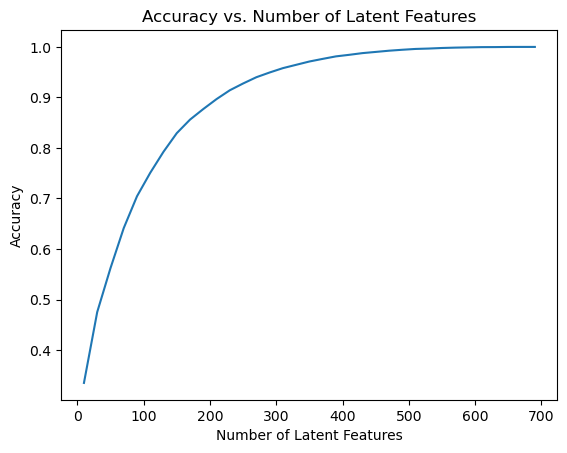

In [343]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [345]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [346]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [347]:
create_user_item_matrix(df_train).index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=5149)

In [348]:
create_user_item_matrix(df_train).columns

Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,   16.0,
         18.0,
       ...
       1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0, 1443.0,
       1444.0],
      dtype='float64', name='article_id', length=714)

In [349]:
df_train.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [517]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_train.index.values
    test_arts = user_item_test.columns.values

    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

#### Here, we take advantage of numpy's methods `intersect1d` and `setdiff1d`. Simply, `np.intersect1d` finds common elements between arrays, while `np.setdiff1d` finds elements in the first array that are not in the second.

The basis for this is because we can predict only what is in BOTH the train and test dataframes, anything unique to each, cant be predicted

In [521]:
print('How many ARTICLES CAN we predict:')
len(np.intersect1d(df_test['article_id'].unique(), df_train['article_id'].unique()))

How many ARTICLES CAN we predict:


574

In [523]:
print('How many USERS CAN we predict for:')
len(np.intersect1d(df_test['user_id'].unique(), df_train['user_id'].unique()))

How many USERS CAN we predict for:


20

In [525]:
print('How many ARTICLES CANT we predict:')
len(np.setdiff1d(df_test['article_id'].unique(), df_train['article_id'].unique()))

How many ARTICLES CANT we predict:


0

In [527]:
print('How many USERS CANT we predict for:')
len(np.setdiff1d(df_test['user_id'].unique(), df_train['user_id'].unique()))

How many USERS CANT we predict for:


662

In [529]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [545]:
# Identify common users and articles between training and test datasets
train_idx = np.array(user_item_train.index)
test_user = np.intersect1d(test_idx, train_idx)
train_arts = np.array(user_item_train.columns)
test_articles = np.intersect1d(test_arts, train_arts)

In [547]:
# Map indices for common users and articles
test_user_idx = np.where(np.in1d(train_idx, test_user))[0]
test_art_idx = np.where(np.in1d(train_arts, test_articles))[0]
test_indexes = np.where(np.in1d(test_idx, test_user))[0]

In [549]:
# Filter the test matrix to include only common users
user_item_test = user_item_test.iloc[test_indexes, :]

In [551]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)
# fit svd similar to above then use the cells below

Setting full_matrices=False in SVD computes reduced matrices for efficiency, using less memory and computation while retaining essential information for matrix reconstruction.

In [554]:
u_train.shape, s_train.shape, vt_train.shape

((5149, 714), (714,), (714, 714))

#### The idea here is to break down the training subset, reconstruct and hen compare it to the test data set.
We have done the above operations to make sure there is no unique value to each of them really, if not we were good to go

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


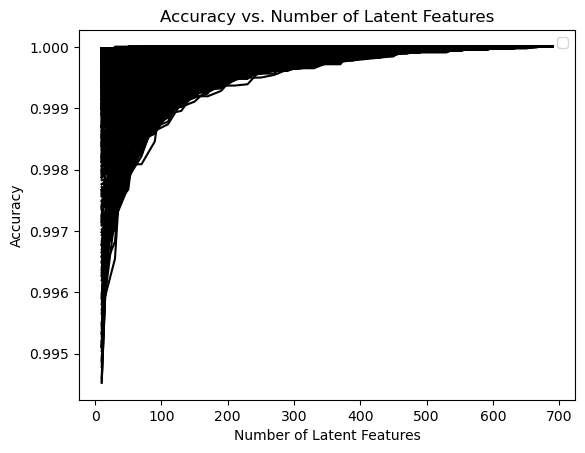

In [576]:
latent_feature_range = np.arange(10, 710, 20)

test_errs = []

for k in latent_feature_range:
    # Restructuring the matrices with k latent features
    s_train_new = np.diag(s_train[:k])
    u_train_new = u_train[:, :k]
    vt_train_new = vt_train[:k, :]

    # Extract relevant parts for test users and articles
    u_test = u_train_new[test_user_idx, :]
    vt_test = vt_train_new[:, test_art_idx]
    
    # Reconstruct the test matrix
    user_item_test_estimation = np.around(np.dot(np.dot(u_test, s_train_new), vt_test))
    
    # Calculate the error between the actual and estimated test matrices
    diffs = np.subtract(user_item_test, user_item_test_estimation)
    err = np.sum(np.abs(diffs))
    test_errs.append(err)

# Plot accuracy vs. number of latent features
plt.figure()
plt.plot(latent_feature_range, 1 - np.array(test_errs) / df.shape[0], color='black')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(loc='best');

## `6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**From the results I have here, there is minimal(almost none even) difference between using SVD on the original matrix and then using it on a training-testing split matrix.
In summary, as the latent features increase, we just tend to get more accurate(closer to 1) without actually getting to 1 itself**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])